<a href="https://colab.research.google.com/github/mascDriver/data-science/blob/main/GEX618_whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt install ffmpeg
!pip install setuptools-rust
!pip install git+https://github.com/openai/whisper.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 9.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-qcob3u9o
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-qcob3u9o
     |████████████████████████████████| 5.8 MB 15.4 MB/s 
     |████████████████████████████████| 7.6 MB 70.4 MB/s 
     |████████████████████████████████| 182 kB 84.9 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175308 sha256=ba6abf22c9be6961aef74375cf6a509bbc6d5fa96b4315eeedac90aeabe61914
  Stored in directory: /tmp/pip-ephem-wheel-cache-1gas2f56/wheels/a7/70/18/b7693c07b1d18b3dafb328f5d0496aa0d41a9c09ef332fd8e6
Successfully built whisper


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import unicodedata
import os

import whisper
import re
import pandas as pd
import torch

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_id(text):
    """
    Convert input text to id.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    text = strip_accents(text.lower())
    text = re.sub('[ ]+', ' ', text)
    text = re.sub('[^0-9a-zA-Z_-]', ' ', text)
    return text
   

class SubtitleAudio():
  def __init__(self, models: tuple, files: tuple) -> None:
    self.models = models
    self.files = files
    self.diff_audio = {}
    self.diff_audio_normalize = {}
    self.results = {}
  
  def transcribe(self, audio, model) -> str:
    """
    Funcao utilizada para fazer a leitura do audio e obter sua resposta usando gpu ou cpu

    :param audio: File for whisper read.
    :type audio: File.

    :returns: The processed String.
    :rtype: String.
    """
    if torch.cuda.is_available():
      # se gpu estiver acessivel utilizamos pelo ganho na velocidade do torch na gpu
      audio = whisper.load_audio(audio)
      audio = whisper.pad_or_trim(audio)
      # carregamento e divisao do audio para uma melhor captura do modelo
      mel = whisper.log_mel_spectrogram(audio).to(model.device)
      _, probs = model.detect_language(mel)
      options = whisper.DecodingOptions()
      result = whisper.decode(model, mel, options)
      return result.text
    else:
      #caso esteja rodando na cpu, precisamos utilizar de modo simples pois a cpu nao suporta as instrucoes passadas na gpu acima
      result = model.transcribe(audio)
      return result['text']
    
  def compare_diff(self, file: str, legends: str, normalize=False) -> int:
    """
    Funcao que recebe qual o arquivo executado e o resultado do whisper

    :param file: Name of file.
    :type file: String.
    :param legends: Original subtitle of file.
    :type legends: String.
    :param normalize: Boolean for use normalize functions.
    :type normalize: Bool.

    :returns: Sum of diffs in files.
    :rtype: Int.
    """
    with open(f"{self.files[1]}/{file}.txt", encoding = 'utf-8') as f:
      words = f.read().replace('\n', '')
      if normalize:
        # quando solicitado removo pontuacao para comparar se isso influencia no resultado
        words = text_to_id(words)
        legends = text_to_id(legends)
      count = sum(1 for a, b in zip(words, legends) if a != b)
      # aqui passo as 2 strings, uma com o texto original e outra com resultado obtido e a cada palavra errada adiciono 1 ao contador
      # assim retornando o total de erros que o whisper teve em cada modelo
      return count

  def run(self) -> None:
    """
      Funcao responsavel por fazer a parte bruta de ler o audio e capturar o retorno do whisper
    """
    for model_base in self.models:
      model = whisper.load_model(model_base)
      for file in os.scandir(self.files[0]):
        filename = file.name.replace('.mp3', '')
        result = self.transcribe(file.path, model)
        # aqui utilizo um dicionario para armazenar todos os resultados em todos modelos assim tendo um dict de dict
        if filename in self.results:
          self.results[filename].update({model_base: result})
        else:
          self.results.update({filename: {model_base: result}})
  
  def get_diff(self) -> None:
    """
      Funcao que compara o resultado bruto do whisper com o texto bruto original
    """
    for filename, results in self.results.items():
      for model_base, result in results.items():
        diff_file = self.compare_diff(filename, result)
        if filename in self.diff_audio:
          self.diff_audio[filename].update({model_base: diff_file})
        else:
          self.diff_audio.update({filename: {model_base: diff_file}})

  def get_diff_normalize(self) -> None:
    """
      Funcao que compara o resultado normalizado do whisper com o texto normalizado original
    """
    for filename, results in self.results.items():
      for model_base, result in results.items():
        diff_file_n = self.compare_diff(filename, result, True)
        if filename in self.diff_audio_normalize:
          self.diff_audio_normalize[filename].update({model_base: diff_file_n})
        else:
          self.diff_audio_normalize.update({filename: {model_base: diff_file_n}})
    


models = ('tiny', 'base', 'small', 'medium', 'large')
file_audio_path = '/content/drive/Shareddrives/Audios Whisper'
file_legends_path = '/content/drive/Shareddrives/Legendas Whisper'


sub_audio = SubtitleAudio(models, (file_audio_path, file_legends_path))
sub_audio.run()
sub_audio.get_diff()
sub_audio.get_diff_normalize()

100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 60.1MiB/s]
100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 35.5MiB/s]
100%|███████████████████████████████████████| 461M/461M [00:09<00:00, 50.5MiB/s]
100%|█████████████████████████████████████| 1.42G/1.42G [00:26<00:00, 57.9MiB/s]
100%|█████████████████████████████████████| 2.87G/2.87G [00:44<00:00, 69.6MiB/s]


In [5]:
pd.DataFrame(sub_audio.diff_audio)

,Alan Watts - The Mind,Jun Making French Toast,Come Out Ye Blacks And Tans,KGLW - People Vultures,Elijah wood wigs,The Ink Spots - I don't want to set the world on fire,Thomas Edison - Phonograph,No Buses - Pretty Old Man,Roosevelt Dictatorships,Men At Work - Down Under
tiny,3,95,220,5,262,81,190,55,143,560
base,160,90,237,5,217,81,189,71,124,25
small,2,321,244,5,216,81,185,84,141,668
medium,165,110,259,23,218,81,158,134,141,38
large,165,95,28,1,139,81,187,102,141,9


In [6]:
pd.DataFrame(sub_audio.diff_audio_normalize)

,Alan Watts - The Mind,Jun Making French Toast,Come Out Ye Blacks And Tans,KGLW - People Vultures,Elijah wood wigs,The Ink Spots - I don't want to set the world on fire,Thomas Edison - Phonograph,No Buses - Pretty Old Man,Roosevelt Dictatorships,Men At Work - Down Under
tiny,0,91,242,5,238,42,188,61,133,542
base,158,89,230,5,212,43,186,69,124,26
small,0,319,205,5,119,42,183,87,0,634
medium,163,110,217,24,187,42,152,132,0,41
large,163,94,0,0,213,42,183,72,0,0


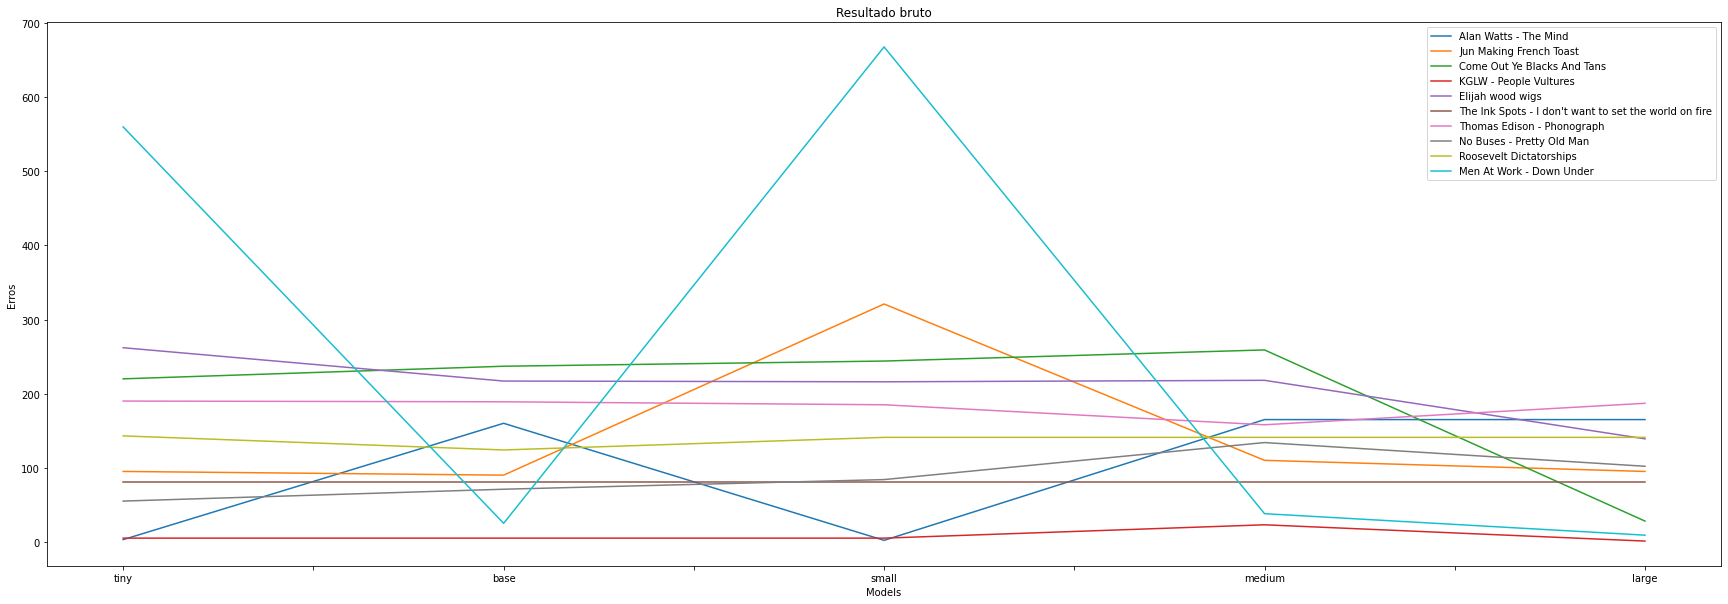

In [7]:
pd.DataFrame(sub_audio.diff_audio).plot(ylabel='Erros', xlabel='Models', title='Resultado bruto', figsize=(30,10))

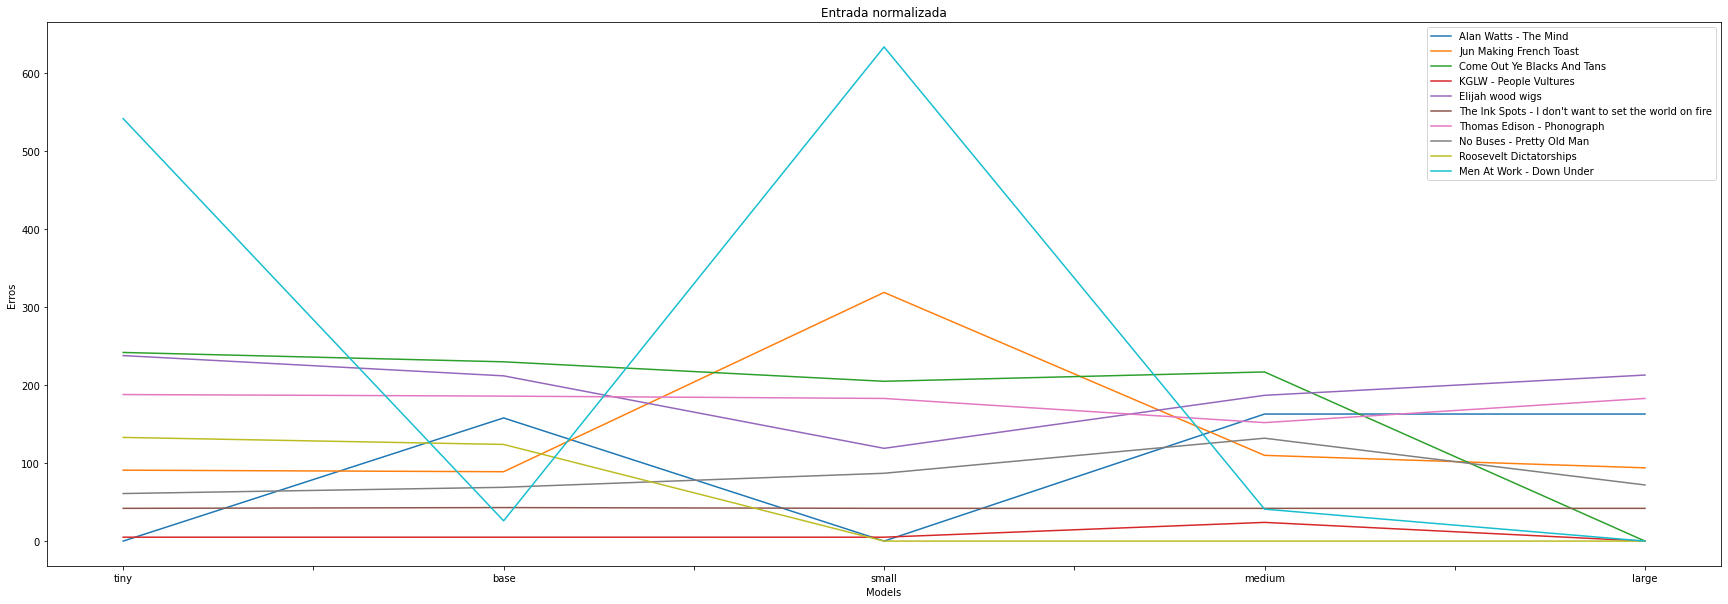

In [8]:
pd.DataFrame(sub_audio.diff_audio_normalize).plot(ylabel='Erros', xlabel='Models', title='Entrada normalizada',figsize=(30,10))

In [12]:
for filename, results in sub_audio.results.items():
  for model_base, result in results.items():
    with open(f"/content/drive/Shareddrives/Resultado Whisper/{filename} - {model_base}.txt", 'x') as f:
      f.write(result)